# Linear Basis function models

$$y(X, W) = \sum_{j=0}^{M-1} w_{j}\phi_{j}(X) = W.TX, \;\;\ \phi_{0}(X)=1$$
- The model is still linear in basis function $W$, or linear in the new features $\Phi(X)$
- I will try the following basis functions:
    - Identity (linear regression).
    - Polynomial Basis.
    - Gaussian Basis.
    - Sigmoidal Basis.  

In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Some basis functions

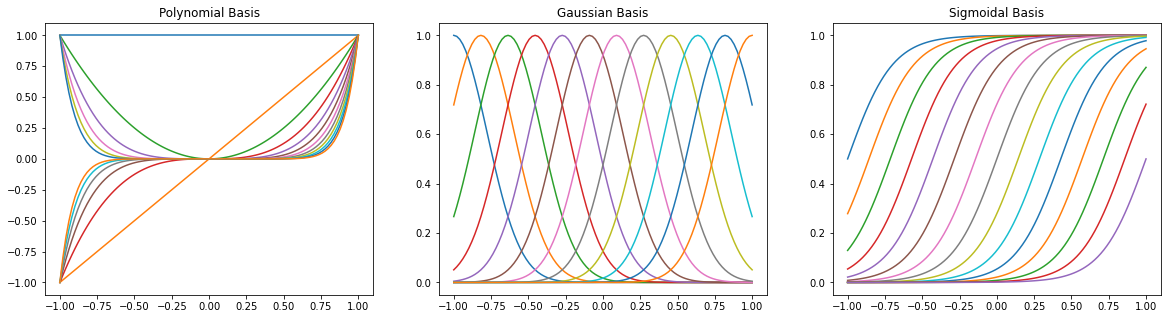

In [2]:
# define x range
x = np.linspace(-1, 1, 100)
# creaet a figure
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# set subplots titles
axes[0].set_title('Polynomial Basis'); axes[1].set_title('Gaussian Basis'); axes[2].set_title('Sigmoidal Basis')
# plot the basis for different parameters
for d in range(0, 12, 1): axes[0].plot(x, np.asarray(list(map(lambda x: x**d, x))))
for mu in np.linspace(-1, 1, 12): axes[1].plot(x, np.exp(-0.5 * np.square(x - mu)/0.05))
for i in np.linspace(-1, 1, 15): axes[2].plot(x, (np.tanh((x - i) / 0.3) + 1 ) / 2) # sig(X) = (tanh(x) + 1)/2

### Genrate the data

In [3]:
def simulator(f, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    noise = np.random.normal(scale=std, size=x.shape)
    t = f(x) + noise
    return x.reshape(sample_size, -1), t

def f(x):
    return np.sin(2 * np.pi * x)

In [4]:
# generate data
def genrate_data(N_tr=10, N_ts=100, std=0.3):
    x_train, y_train = simulator(f, N_tr, std)
    x_test = np.linspace(0, 1, N_ts)
    y_test = f(x_test)
    return x_train, y_train, x_test, y_test

In [5]:
X_train, y_train, X_test, y_test = genrate_data(N_tr=9)

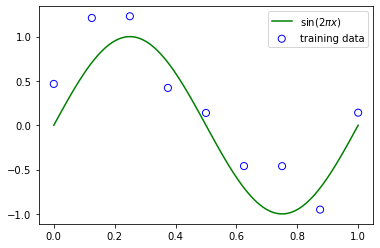

In [6]:
# plot the data
plt.figure(figsize=(6, 4))
plt.scatter(X_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(X_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

### Using Basis functions (Identity, Polynomial, Gaussian, Sigmoidal)

In [7]:
# the identity
def Identity(X):
    return X

# generate polynomial basis
def PolynomialFeature(X, degrees):
    
    X_poly = X.copy()
    
    for i in range(2, degrees+2):
        X_poly = np.append(X_poly, X**i, axis=1)
    
    return X_poly

# genrate gaussian basis
def GaussianFeatures(X, mu, sigma):
    
    if isinstance(mu, int):
        mu = [mu]    
    
    X_Gauss = X.copy()
    
    for m in mu:
        X_Gauss = np.append(X_Gauss, np.exp(-0.5 * np.square(X - m)/s), axis=1)
    
    return np.array(X_Gauss).reshape(X.shape[0], -1)

def SigmoidalFeatures(X, mu, sigma):
    
    if isinstance(mu, int):
        mu = [mu] 
    
    X_Sig = X.copy()
    
    for m in mu:
        X_Sig = np.append(X_Sig, (np.tanh((X - m) / s) + 1 ) / 2, axis=1)
    
    return np.array(X_Sig).reshape(X.shape[0], -1)

#### Fit linear models using Least-Squares after scaling the features to avoid training data matrix singularity

In [8]:
class OLS:
    """
    Linear regression model.
    y = W^T X
    t ~ N(t|W^T X, B^-1)
    """
    def __init__(self):
        pass
    
    def _scale_fit(self, X, L=-1, H=1):
        P = X.shape[1]
        self.a = []; self.b = []
        for p in range(P):
            self.a.append(((H * min(X[:, p])) - (L * max(X[:, p])))/(H-L))
            self.b.append((max(X[:, p]) - min(X[:, p]))/(H - L))

    def _scale_transform(self, X):
        X_scaled = (X - self.a)/self.b
        return X_scaled.reshape(X.shape[0], -1)
    
    def _scale_inverse(X):
        return (X * self.b) + selfa
    
    def fit(self, X, y, scale=True):
        self.scale = scale
        self.N, self.P = X.shape
        # add cloumn of ones in X for the bias term
        if self.scale:
            self._scale_fit(X)
            X = self._scale_transform(X)
        X = np.append(X, np.ones((self.N, 1)), axis=1)   
        y = y.reshape(self.N, 1)
        # The Normal Equation W(ML) = (X^T X)^-1 X^T Y
        self.W = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y)).flatten()
        self.B_inv = np.mean(np.square(np.dot(X, self.W) - y))

    def predict(self, X, std=False):
        
        if self.scale:
            X = self._scale_transform(X)
        
        X = X.reshape(-1, self.P)
        X = np.append(X, np.ones((X.shape[0],1)), axis=1)
        preds = np.dot(X, self.W)
        if std:
            std_ = np.sqrt(self.B_inv) + np.zeros_like(preds)
            return y, std_
        return preds

#### Function to plot learning results 

In [35]:
def plot_results(X_tr, y_tr, X_ts, y_ts, pred, ax, title=None, text=None):
    ax.scatter(X_tr, y_tr, facecolor="none", edgecolor="b", s=50, label="training data")
    ax.plot(X_ts, pred, 'r', label='Regression line')
    ax.plot(X_ts, y_ts, c="g", label="$\sin(2\pi x)$")
    ax.set_xlabel('$X$', size=15)
    ax.set_ylabel('$Y$', rotation=0, size=15)
    if title:
        ax.set_title(title, fontsize=16)
    if text:
        ax.set_ylim(-1.6, 2)
        ax.text(0, 1.7, text, size=20)
    ax.legend()
    return ax

### 1) The identity basis function $\Phi(X) = X$

In [37]:
Id_X = Identity(X_train)
Id_X_test = Identity(X_test.reshape(-1, 1))

In [38]:
model = OLS()
model.fit(Id_X.reshape(-1, 1), y_train, scale=True)

In [39]:
model.W

array([-0.79429232,  0.01153201])

In [40]:
y_pred = model.predict(Id_X_test.reshape(-1, 1))

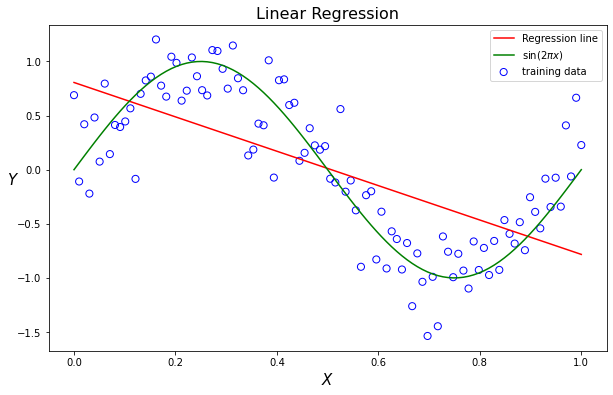

In [41]:
# Plot the regression line
_, ax = plt.subplots(figsize=(10, 6))
plot_results(Id_X, y_train, Id_X_test, y_test, y_pred, ax, 'Linear Regression');

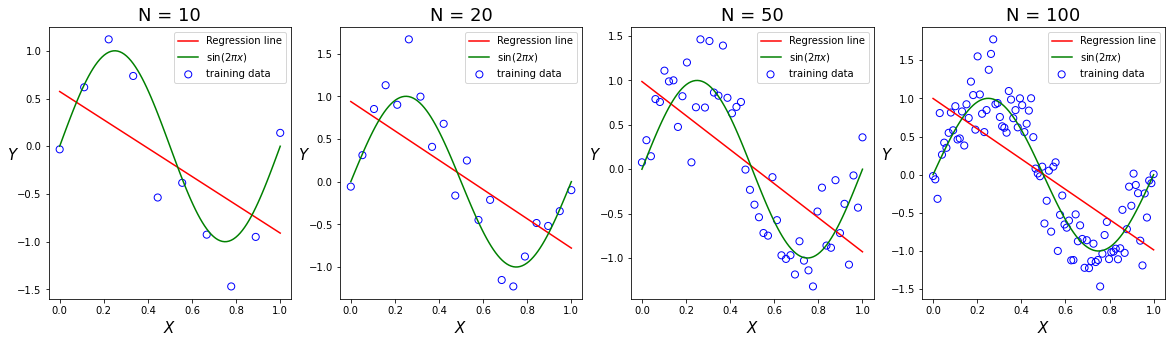

In [15]:
_, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, n in enumerate([10, 20, 50, 100]):
    X_train, y_train, X_test, y_test = genrate_data(n)
    model = OLS()
    model.fit(X_train.reshape(-1, 1), y_train, scale=True)
    y_pred = model.predict(X_test.reshape(-1, 1))
    plot_results(X_tr=X_train, y_tr=y_train, X_ts=X_test, y_ts=y_test, pred=y_pred, ax=axes[i], title='N = %d'%n)

### 2) The Polynomial basis function $\Phi(X) = \sum_{j=1}^M X^j$

In [16]:
degree = 3
Poly_X = PolynomialFeature(X_train, degree)
Poly_X_test = PolynomialFeature(X_test.reshape(-1, 1), degree)

In [17]:
X_train.shape, Poly_X.shape, X_test.shape, Poly_X_test.shape

((100, 1), (100, 4), (100,), (100, 4))

In [19]:
poly_model = OLS()
poly_model.fit(Poly_X, y_train, scale=True)

In [20]:
y_pred_poly = poly_model.predict(Poly_X_test)

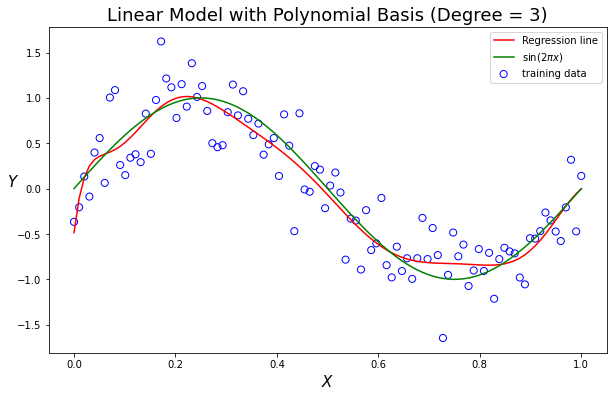

In [21]:
# Plot the regression line
_, ax = plt.subplots(figsize=(10, 6))
plot_results(X_tr=X_train, y_tr=y_train, X_ts=X_test, y_ts=y_test, pred=y_pred_poly, 
             ax=ax, title='Linear Model with Polynomial Basis (Degree = %d)'%degree);

#### Fit with different degrees for different sample size for training

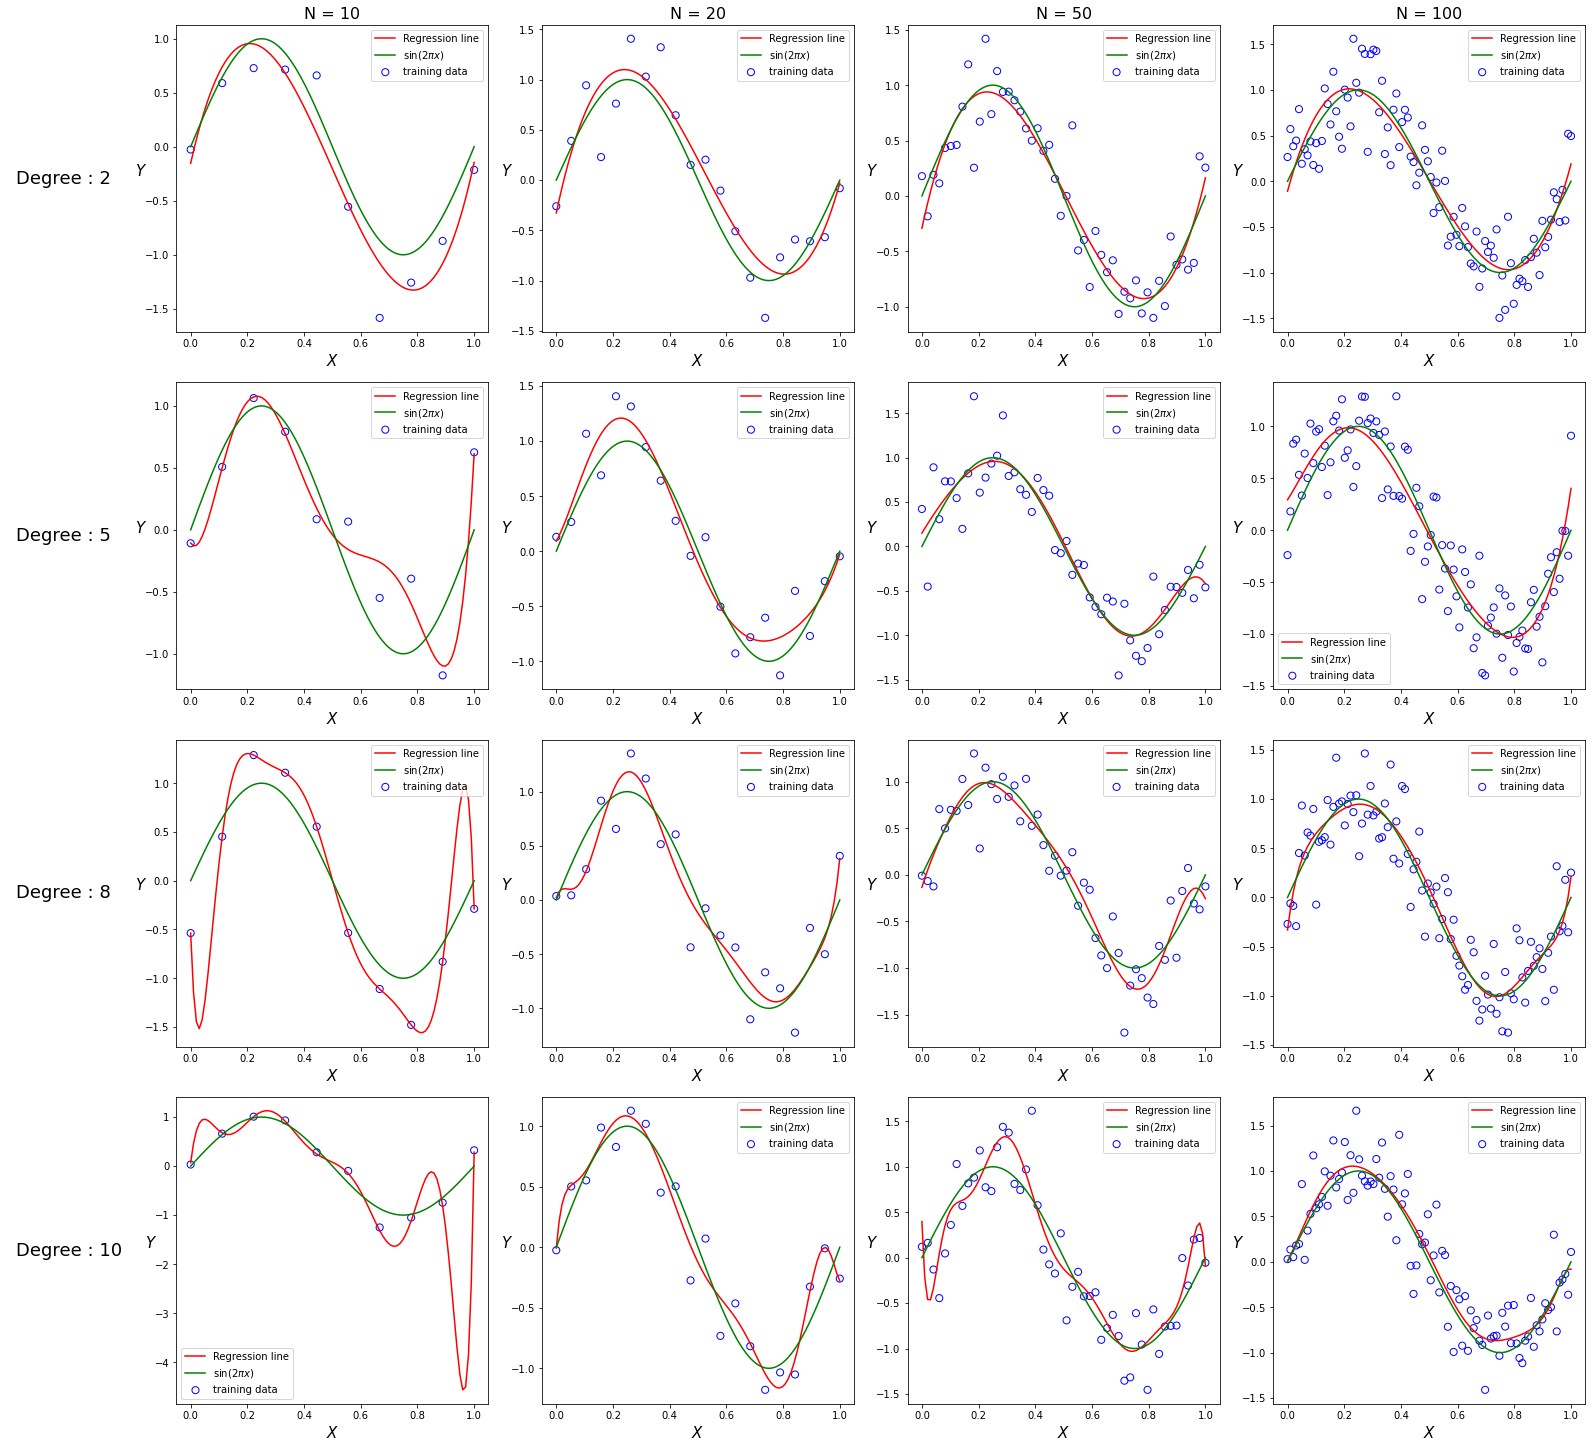

In [42]:
fig = plt.figure(constrained_layout=True, figsize=(22, 20))
widths = [0.8, 3, 3, 3, 3]; heights = [1, 1, 1, 1]
N_s = [10, 20, 50, 100]; D_s = [2, 5, 8, 10]
spec = fig.add_gridspec(ncols=5, nrows=4, width_ratios=widths, height_ratios=heights)

for row, d in enumerate(D_s):
    ax = fig.add_subplot(spec[row, 0])
    ax.annotate('Degree : %s'%D_s[row], (0.1, 0.5), xycoords='axes fraction', va='center', size=18)
    ax.axis('off')
    for col, n in enumerate(N_s):
        ax = fig.add_subplot(spec[row, col+1])
        title = None if row > 0 else 'N = %d'%n
        X_train, y_train, X_test, y_test = genrate_data(n)
        Poly_X = PolynomialFeature(X_train, d)
        Poly_X_test = PolynomialFeature(X_test.reshape(-1, 1), d)
        X_train.shape, Poly_X.shape, X_test.shape, Poly_X_test.shape
        poly_model = OLS()
        poly_model.fit(Poly_X, y_train, scale=True)
        y_pred_poly = poly_model.predict(Poly_X_test)
        plot_results(X_tr=X_train, y_tr=y_train, X_ts=X_test, y_ts=y_test, pred=y_pred_poly, ax=ax, title=title);

### 3) The Gaussian basis function $\Phi(X) = \sum_{j=1}^M N(X|mu_{j}, s_{j})$

In [23]:
mu, s = np.linspace(0, 1, 5), 0.01
Gauss_X = GaussianFeatures(X_train, mu, s)
Gauss_X_test = GaussianFeatures(X_test.reshape(-1, 1), mu, s)

In [24]:
X_train.shape, Gauss_X.shape, X_test.shape, Gauss_X_test.shape, 

((100, 1), (100, 6), (100,), (100, 6))

In [25]:
gauss_model = OLS()
gauss_model.fit(Gauss_X, y_train, scale=True)

In [26]:
y_pred_gauss = gauss_model.predict(Gauss_X_test)

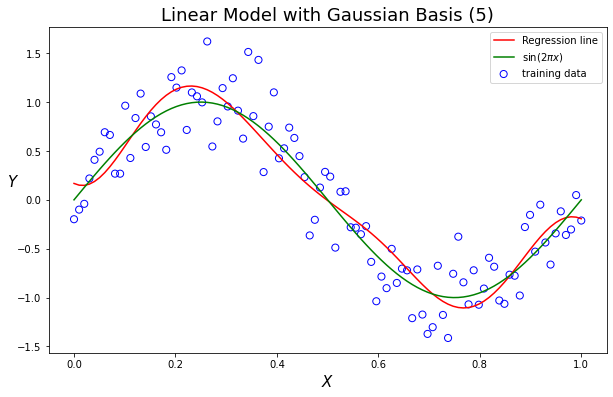

In [27]:
# Plot the regression line
_, ax = plt.subplots(figsize=(10, 6))
plot_results(X_tr=X_train, y_tr=y_train, X_ts=X_test, y_ts=y_test, pred=y_pred_gauss,
             ax=ax, title='Linear Model with Gaussian Basis (5)');

#### Fit with different degrees for different sample size for training

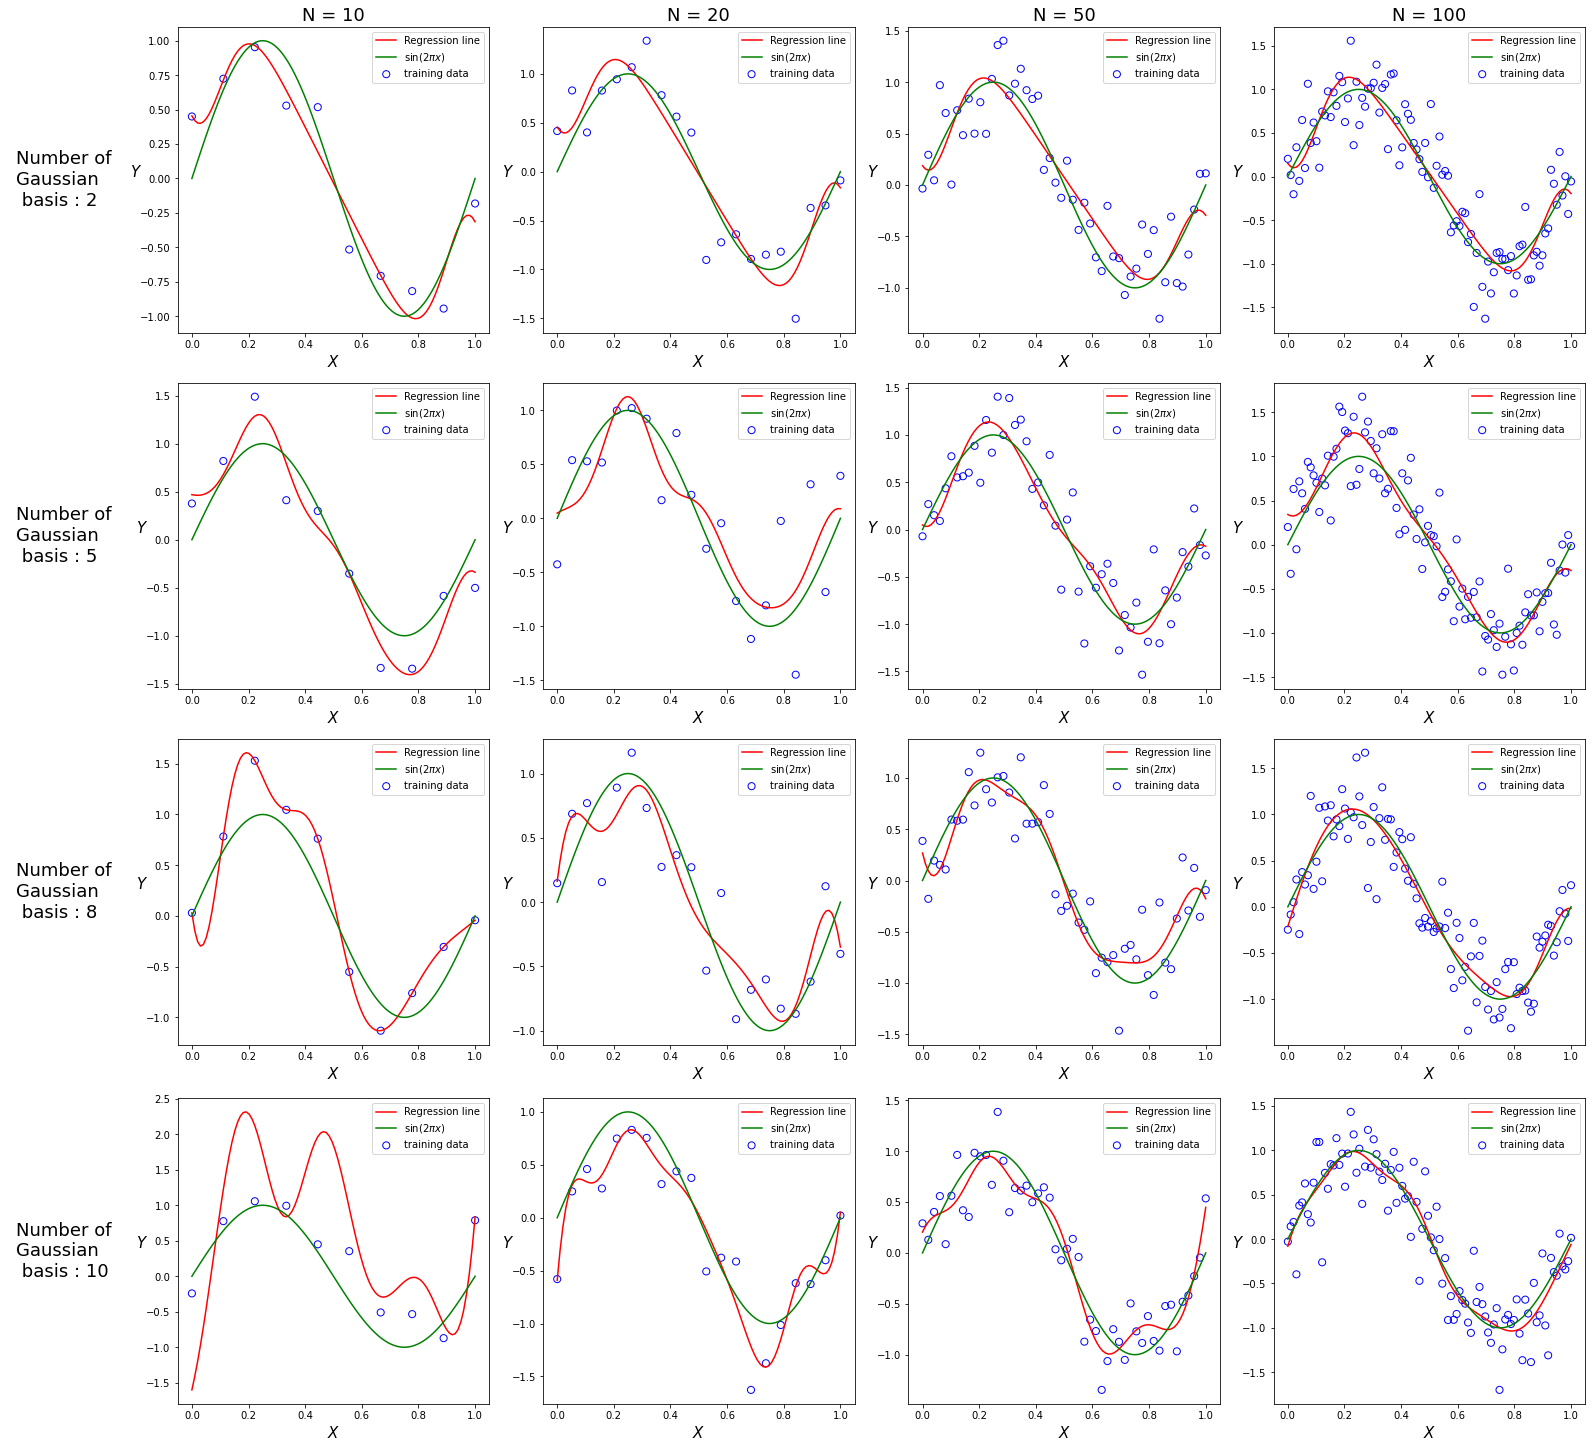

In [28]:
fig = plt.figure(constrained_layout=True, figsize=(22, 20))
widths = [0.8, 3, 3, 3, 3]; heights = [1, 1, 1, 1]
N_s = [10, 20, 50, 100]; G_s = [2, 5, 8, 10]
spec = fig.add_gridspec(ncols=5, nrows=4, width_ratios=widths, height_ratios=heights)

for row, g in enumerate(G_s):
    ax = fig.add_subplot(spec[row, 0])
    ax.annotate('Number of \nGaussian\n basis : %s'%G_s[row], (0.1, 0.5), xycoords='axes fraction', va='center', size=18)
    ax.axis('off')
    for col, n in enumerate(N_s):
        ax = fig.add_subplot(spec[row, col+1])
        title = None if row > 0 else 'N = %d'%n
        X_train, y_train, X_test, y_test = genrate_data(n)
        Poly_X = GaussianFeatures(X_train, np.linspace(0, 1, g), 0.01)
        Poly_X_test = GaussianFeatures(X_test.reshape(-1, 1), np.linspace(0, 1, g), 0.01)
        X_train.shape, Poly_X.shape, X_test.shape, Poly_X_test.shape
        poly_model = OLS()
        poly_model.fit(Poly_X, y_train, scale=True)
        y_pred_poly = poly_model.predict(Poly_X_test)
        plot_results(X_tr=X_train, y_tr=y_train, X_ts=X_test, y_ts=y_test, pred=y_pred_poly, ax=ax, title=title);

### 2) The Sigmoidal basis function $\Phi(X) = \sum_{j=1}^M sig_{j}(\frac{X-\mu}{S})$,  where $sig(a) = \frac{1}{1+\exp(-a)}$

In [29]:
mu, s = np.linspace(0, 1, 5), 0.01
Sig_X = SigmoidalFeatures(X_train, mu, s)
Sig_X_test = SigmoidalFeatures(X_test.reshape(-1, 1), mu, s)

In [30]:
X_train.shape, Sig_X.shape, Sig_X_test.shape, Sig_X_test.shape

((100, 1), (100, 6), (100, 6), (100, 6))

In [31]:
sig_model = OLS()
sig_model.fit(Sig_X, y_train, scale=True)

In [32]:
y_pred_sig = gauss_model.predict(Gauss_X_test)

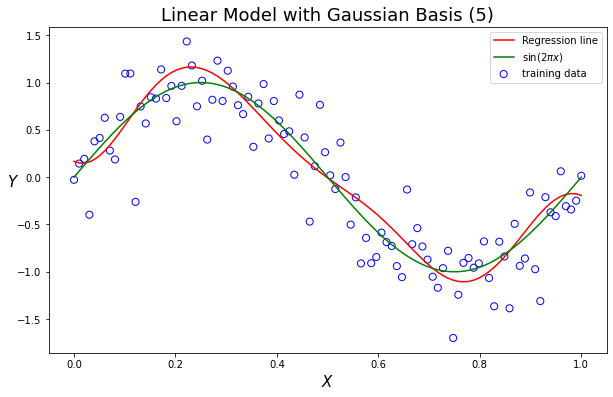

In [33]:
# Plot the regression line
_, ax = plt.subplots(figsize=(10, 6))
plot_results(X_tr=X_train, y_tr=y_train, X_ts=X_test, y_ts=y_test, pred=y_pred_sig,
             ax=ax, title='Linear Model with Gaussian Basis (5)');

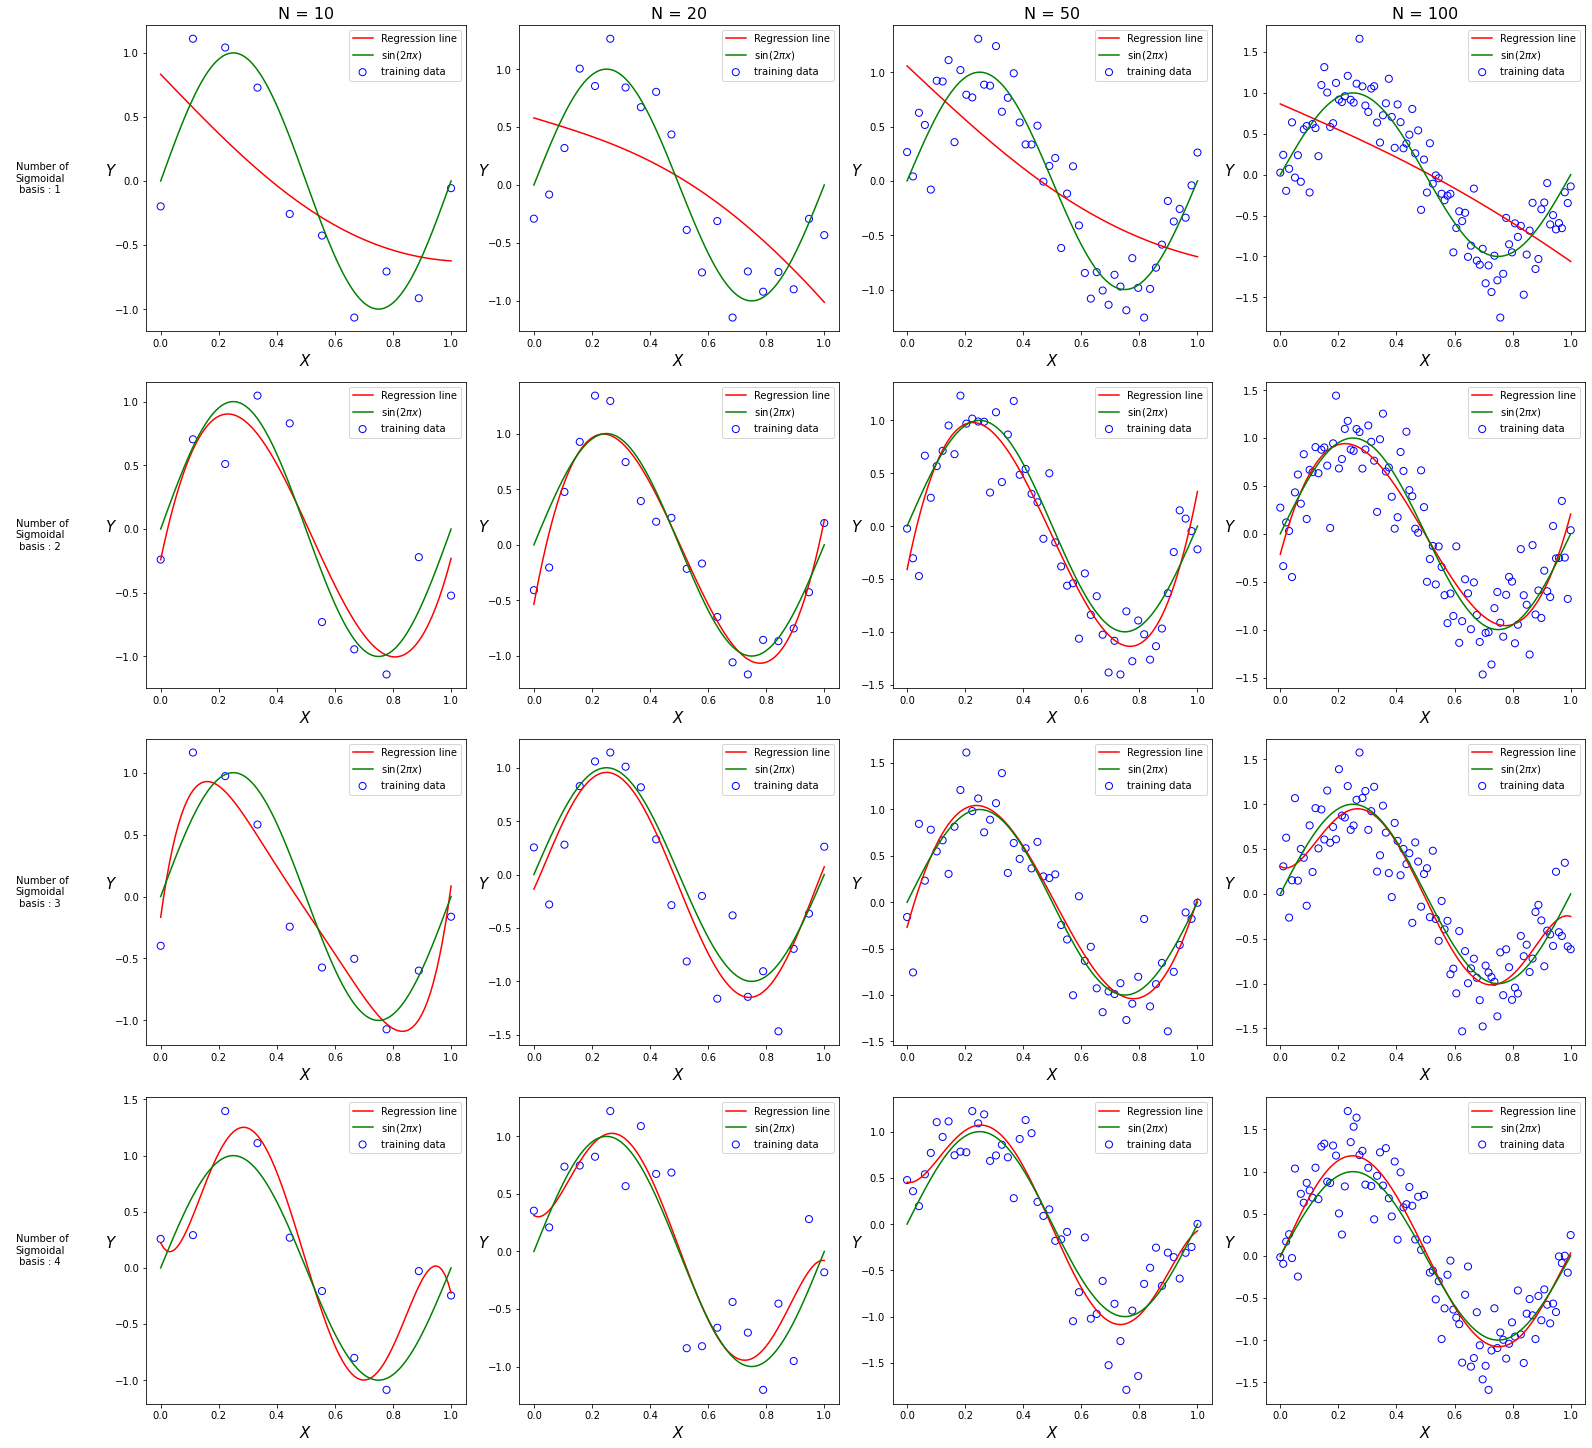

In [43]:
fig = plt.figure(constrained_layout=True, figsize=(22, 20))
widths = [0.8, 3, 3, 3, 3]; heights = [1, 1, 1, 1]
N_s = [10, 20, 50, 100]; S_s = [1, 2, 3, 4]
spec = fig.add_gridspec(ncols=5, nrows=4, width_ratios=widths, height_ratios=heights)

for row, s in enumerate(S_s):
    ax = fig.add_subplot(spec[row, 0])
    ax.annotate('Number of \nSigmoidal\n basis : %s'%S_s[row], (0.1, 0.5), xycoords='axes fraction', va='center')
    ax.axis('off')
    for col, n in enumerate(N_s):
        ax = fig.add_subplot(spec[row, col+1])
        title = None if row > 0 else 'N = %d'%n
        X_train, y_train, X_test, y_test = genrate_data(n)
        Poly_X = SigmoidalFeatures(X_train, np.linspace(0, 1, s), 0.01)
        Poly_X_test = SigmoidalFeatures(X_test.reshape(-1, 1), np.linspace(0, 1, s), 0.01)
        X_train.shape, Poly_X.shape, X_test.shape, Poly_X_test.shape
        poly_model = OLS()
        poly_model.fit(Poly_X, y_train, scale=True)
        y_pred_poly = poly_model.predict(Poly_X_test)
        plot_results(X_tr=X_train, y_tr=y_train, X_ts=X_test, y_ts=y_test, pred=y_pred_poly, ax=ax, title=title);

# Conclusion
<h4><li> The process of fitting is greatly impacted by adding basis functions.
<h4><li> The likelihood of overfitting increases as we increase the degree of the polynomial (number of gaussian or sigmoidal basis).
<h4><li> For the same degree (number of gaussian or sigmoidal basis), the overfitting effect disappears as the data size rises.